# **Transforming Non-Stationary IPL Time Series Data to Stationary Data**

## **Introduction**

Time series data in cricket, such as team performance or player statistics over seasons, often exhibits trends, seasonality, or fluctuations. However, many forecasting models, like ARIMA, require the data to be **stationary**—where statistical properties like mean, variance, and autocorrelation remain constant over time. 

In this analysis, we focus on transforming non-stationary time series data from the Indian Premier League (IPL) into stationary data. Using historical performance data (e.g., average runs per match for Mumbai Indians), we will:

- Detect and visualize non-stationarity.
- Use statistical tests like ADF and KPSS to confirm stationarity.
- Apply transformations like differencing and log transformations to stabilize the data.
- Prepare the transformed data for forecasting future performance. 

This process is crucial for accurate predictions and deeper insights into patterns within IPL data.


## 1. Generating the Dataset <a id="1"></a>

### 1.1 Dataset Description

For this analysis, we will create a synthetic time series dataset representing the **average runs scored by Mumbai Indians per match** over multiple IPL seasons. The dataset will be constructed with the following characteristics:

- **Time Frame**: The dataset spans over **16 IPL seasons**, starting from 2008 to 2023.
- **Variables**:
  - **Season**: The year of the IPL season (2008, 2009, ..., 2023).
  - **Average_Runs_Per_Match**: The average runs scored by Mumbai Indians in each match during that particular season.
  
The dataset will provide a temporal view of Mumbai Indians' batting performance, capturing both the overall performance trend and any variations across the seasons.


In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Normalize the runs for better performance
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [334]:
df =pd.read_csv('ipl_data.csv')

In [335]:
# Group by 'season' and 'current_innings' to calculate matches played
matches_per_innings = df.groupby(['season', 'current_innings'])['match_id'].nunique().reset_index()
matches_per_innings.columns = ['season', 'Teams', 'matches_played']

# Group by 'season' and 'current_innings' to calculate total runs scored
runs_per_innings = df.groupby(['season', 'current_innings'])['runs'].sum().reset_index()
runs_per_innings.columns = ['season', 'Teams', 'total_runs_scored']

# Merge the matches and runs data
innings_summary = pd.merge(matches_per_innings, runs_per_innings, on=['season', 'Teams'], how='inner')

# Calculate total matches and total runs for each innings across seasons
innings_data = innings_summary.groupby(['season', 'Teams'])[['matches_played', 'total_runs_scored']].sum().reset_index()

# Calculate the average runs per match for each innings
innings_data['average_runs_per_match'] = innings_data['total_runs_scored'] / innings_data['matches_played']

# Sort the results by average runs per match (optional)
innings_data = innings_data.sort_values('average_runs_per_match', ascending=False)

# Filter the data for matches involving Mumbai Indians
mumbai_indians_data = innings_data[innings_data['Teams'] == 'MI']
mumbai_indians_avg_runs = mumbai_indians_data[['season', 'average_runs_per_match']]

# Display the result without the index
print(mumbai_indians_avg_runs.to_string(index=False))


 season  average_runs_per_match
   2023              182.375000
   2020              169.500000
   2015              169.187500
   2010              169.125000
   2018              168.571429
   2019              166.125000
   2017              162.647059
   2022              157.285714
   2014              156.400000
   2016              156.285714
   2013              155.947368
   2021              149.785714
   2008              147.142857
   2012              144.823529
   2009              143.846154
   2011              142.312500


In [338]:
# Check if mumbai_indians_avg_runs is a Series and convert it to a DataFrame
if isinstance(mumbai_indians_avg_runs, pd.Series):
    mumbai_indians_avg_runs = mumbai_indians_avg_runs.reset_index()

# Ensure 'season' is in datetime format
mumbai_indians_avg_runs['season'] = pd.to_datetime(mumbai_indians_avg_runs['season'], format='%Y', errors='coerce')

# Sort the DataFrame by 'season' in ascending order
mumbai_indians_avg_runs = mumbai_indians_avg_runs.sort_values(by='season').reset_index(drop=True)

# Display the sorted DataFrame
print(mumbai_indians_avg_runs)


       season  average_runs_per_match
0  2008-01-01              147.142857
1  2009-01-01              143.846154
2  2010-01-01              169.125000
3  2011-01-01              142.312500
4  2012-01-01              144.823529
5  2013-01-01              155.947368
6  2014-01-01              156.400000
7  2015-01-01              169.187500
8  2016-01-01              156.285714
9  2017-01-01              162.647059
10 2018-01-01              168.571429
11 2019-01-01              166.125000
12 2020-01-01              169.500000
13 2021-01-01              149.785714
14 2022-01-01              157.285714
15 2023-01-01              182.375000


## 2. Visualizing the Data <a id="2"></a>

### 2.1 Plotting the Time Series

In this step, we will visualize the synthetic time series data representing Mumbai Indians' **average runs per match** across the seasons. Plotting this data allows us to identify any visible trends, seasonal patterns, or non-stationarity in the data.

We will create a line plot, with the **seasons** on the x-axis and **average runs per match** on the y-axis. This helps in visually inspecting the trend of Mumbai Indians' performance over time.


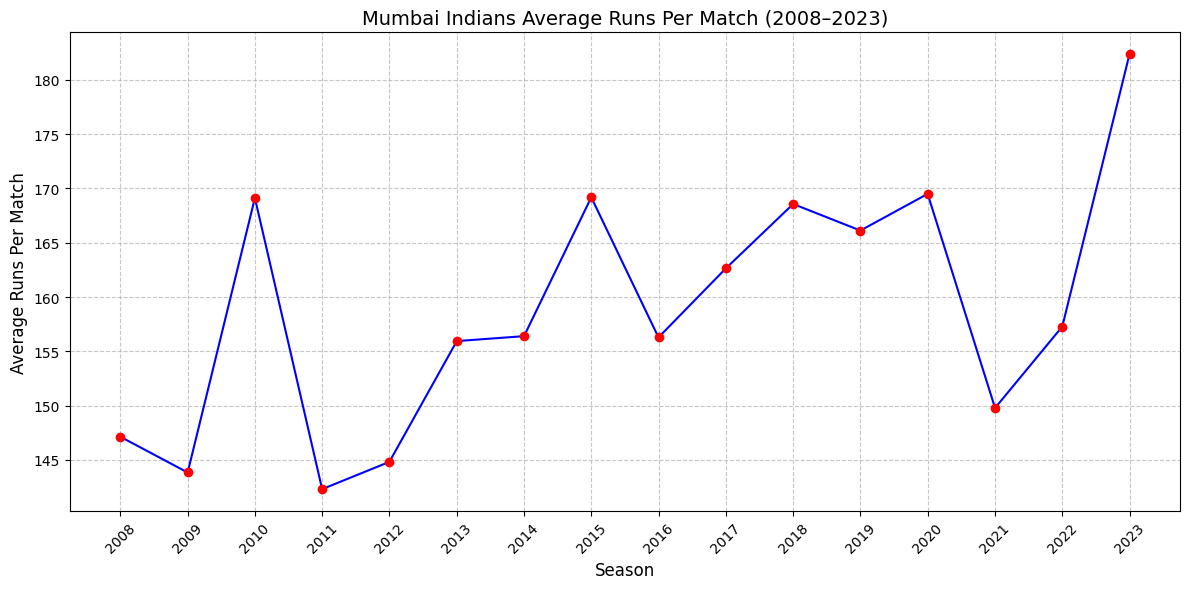

In [341]:

# Ensure x and y are correctly defined
x = mumbai_indians_avg_runs['season']
y = mumbai_indians_avg_runs['average_runs_per_match']
a=x
b=y
plt.figure(figsize=(12, 6))

# Plot the smooth line for Mumbai Indians average runs per match
plt.plot(
    x, 
    y, 
    color='blue', 
    linestyle='-', 
    label='Mumbai Indians (Smooth)'
)

# Add original data points as red scatter plot
plt.scatter(
    x, 
    y, 
    color='red', 
    label='Original Data', 
    zorder=5
)

# Add titles and labels
plt.title('Mumbai Indians Average Runs Per Match (2008–2023)', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Runs Per Match', fontsize=12)

# Replace x-ticks with the actual season years
plt.xticks(
    ticks=x,
    labels=mumbai_indians_avg_runs['season'].dt.year if mumbai_indians_avg_runs['season'].dtype == 'datetime64[ns]' else mumbai_indians_avg_runs['season'],
    fontsize=10,
    rotation=45
)

# Add grid and legend
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()  

**Observation**: The plot shows an upward trend with seasonal fluctuations, indicating non-stationarity.

### 2.2 Histogram and Density Plot

To further understand the distribution of Mumbai Indians' **average runs per match**, we can create a histogram and a density plot. These plots will allow us to visually assess whether the data follows a normal distribution and identify any skewness or patterns that may indicate non-stationarity.

#### Histogram

The histogram shows the frequency of different average runs per match over the seasons, which helps us understand the overall distribution of the data.

#### Density Plot

The density plot is a smoothed version of the histogram and can help visualize the distribution's shape more clearly.


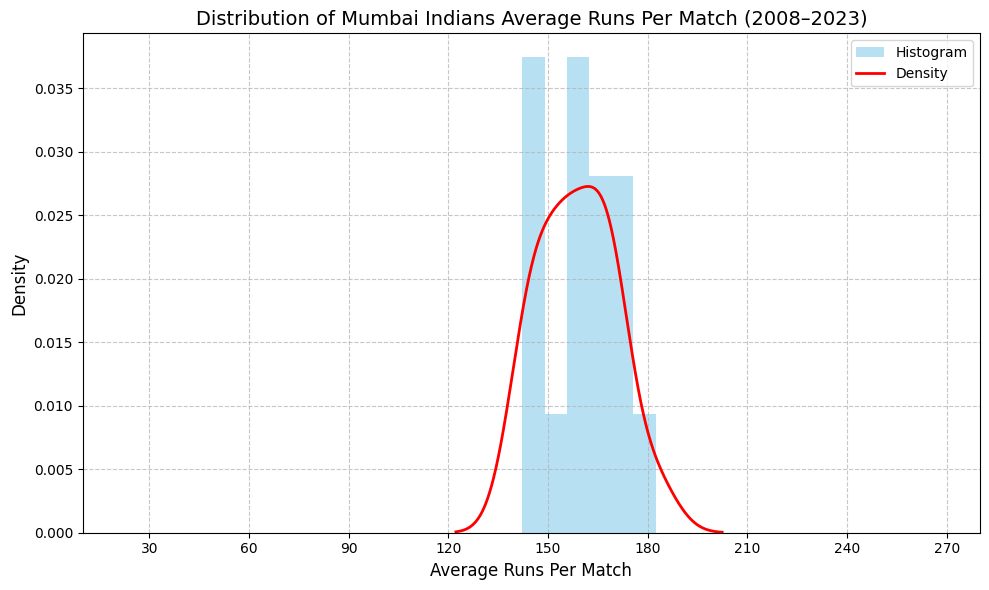

In [231]:
from matplotlib.ticker import MaxNLocator

# Plot setup
plt.figure(figsize=(10, 6))

# Histogram for Mumbai Indians' average runs per match
mumbai_indians_avg_runs['average_runs_per_match'].plot(
    kind='hist', 
    bins=6, 
    density=True, 
    alpha=0.6, 
    color='skyblue', 
    label='Histogram'
)

# KDE (Density Curve) for Mumbai Indians' average runs per match
mumbai_indians_avg_runs['average_runs_per_match'].plot(
    kind='kde', 
    color='red', 
    linewidth=2, 
    label='Density'
)

# Set x-axis limits to range from -20 to 140
plt.xlim(10, 280)

# Adjust x-axis ticks using MaxNLocator to reduce the tick frequency
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=9))  # Adjust nbins to control number of ticks

# Add title and labels
plt.title('Distribution of Mumbai Indians Average Runs Per Match (2008–2023)', fontsize=14)
plt.xlabel('Average Runs Per Match', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Add legend
plt.legend(fontsize=10)

# Show plot
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



### 3.2 Outlier Detection

In time series data, outliers can significantly affect the model's performance and the results of statistical tests. Outliers can occur due to a variety of reasons, such as errors in data collection or unusual events (e.g., an exceptionally high number of runs in a particular match).

We will perform **outlier detection** to identify any data points that significantly deviate from the overall trend. In this section, we will use:

1. **Boxplot**: A boxplot provides a visual indication of outliers based on the interquartile range (IQR).
2. **Z-Score**: Z-scores help to quantify how far a data point is from the mean.

#### Boxplot

A boxplot will help us visualize the spread of the data and identify any potential outliers.


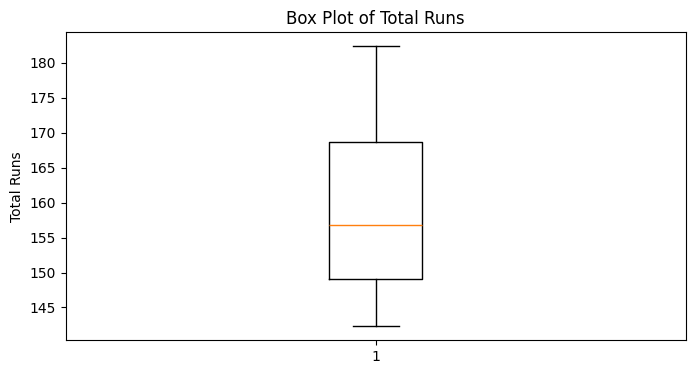

In [234]:
plt.figure(figsize=(8, 4))
plt.boxplot(mumbai_indians_avg_runs['average_runs_per_match'])
plt.title('Box Plot of Total Runs')
plt.ylabel('Total Runs')
plt.show()

### 3.3 Feature Engineering

Feature engineering is a crucial step in preparing the data for forecasting. It involves creating new variables that might help improve model accuracy. In time series forecasting, **lag features** are particularly useful as they capture the dependency of the current value on its past values.

#### Lag Features

A **lag feature** is a previous value in the time series that might help in predicting future values. For example, a lag of 1 would be the value from the previous season, a lag of 2 would be the value from two seasons ago, and so on. We will create lag features to help capture trends from the previous IPL seasons.


In [237]:
# Creating Lag_1 and Lag_2 columns
mumbai_indians_avg_runs['Lag_1'] = mumbai_indians_avg_runs['average_runs_per_match'].shift(1)
mumbai_indians_avg_runs['Lag_2'] = mumbai_indians_avg_runs['average_runs_per_match'].shift(2)

# Extract Month and Year from 'season' column (assuming 'season' is in datetime format)
mumbai_indians_avg_runs['Month'] = pd.to_datetime(mumbai_indians_avg_runs['season']).dt.month
mumbai_indians_avg_runs['Year'] = pd.to_datetime(mumbai_indians_avg_runs['season']).dt.year



---

## 4. Stationarity Check <a id="4"></a>

### 4.1 Autocorrelation and Partial Autocorrelation Plots

#### Autocorrelation Function (ACF) Plot

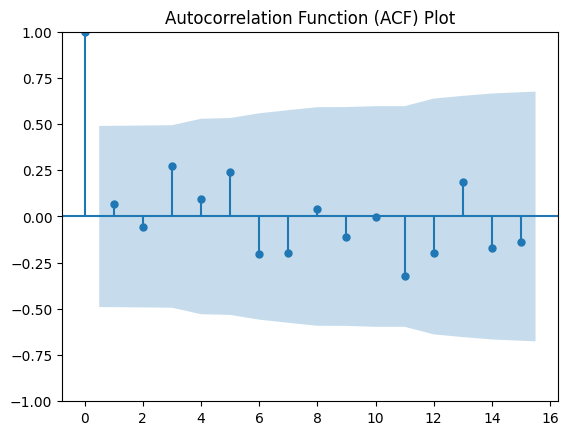

In [240]:
from statsmodels.graphics.tsaplots import plot_acf

# Check the length of the data to avoid exceeding available lags
max_lags = min(len(mumbai_indians_avg_runs['average_runs_per_match'].dropna()) - 1, 50)

# Plot the ACF for the 'average_runs_per_match' column with a lower lag
plot_acf(mumbai_indians_avg_runs['average_runs_per_match'].dropna(), lags=max_lags)

# Title for the ACF plot
plt.title('Autocorrelation Function (ACF) Plot')

# Show the plot
plt.show()


#### Partial Autocorrelation Function (PACF) Plot

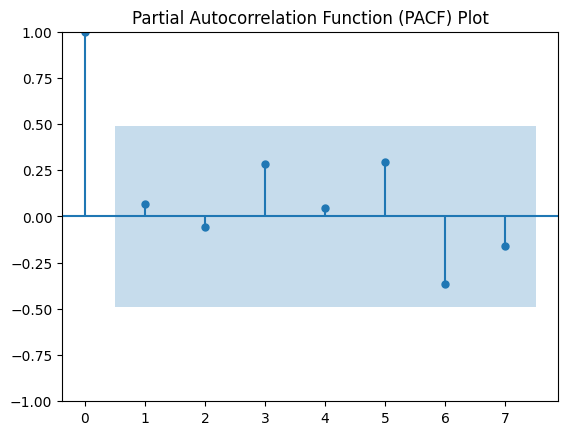

In [243]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(mumbai_indians_avg_runs['average_runs_per_match'].dropna(), lags=7)
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.show()



### 4.2 Augmented Dickey-Fuller (ADF) Test

In [246]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(mumbai_indians_avg_runs['average_runs_per_match'].dropna())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.577913
p-value: 0.875895
Critical Values:
	1%: -4.473
	5%: -3.290
	10%: -2.772


**Interpretation**:

- **Null Hypothesis (H0)**: The series is non-stationary.
- If **p-value > 0.05**, fail to reject H0; the series is non-stationary.

### 4.3 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

In [249]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(mumbai_indians_avg_runs['average_runs_per_match'].dropna(), regression='c')
print('KPSS Statistic: %f' % kpss_result[0])
print('p-value: %f' % kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.559340
p-value: 0.028302
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


**Interpretation**:

- **Null Hypothesis (H0)**: The series is stationary.
- If **p-value < 0.05**, reject H0; the series is non-stationary.

---

## 5. Making the Data Stationary <a id="5"></a>

### 5.1 Differencing

#### First Order Differencing

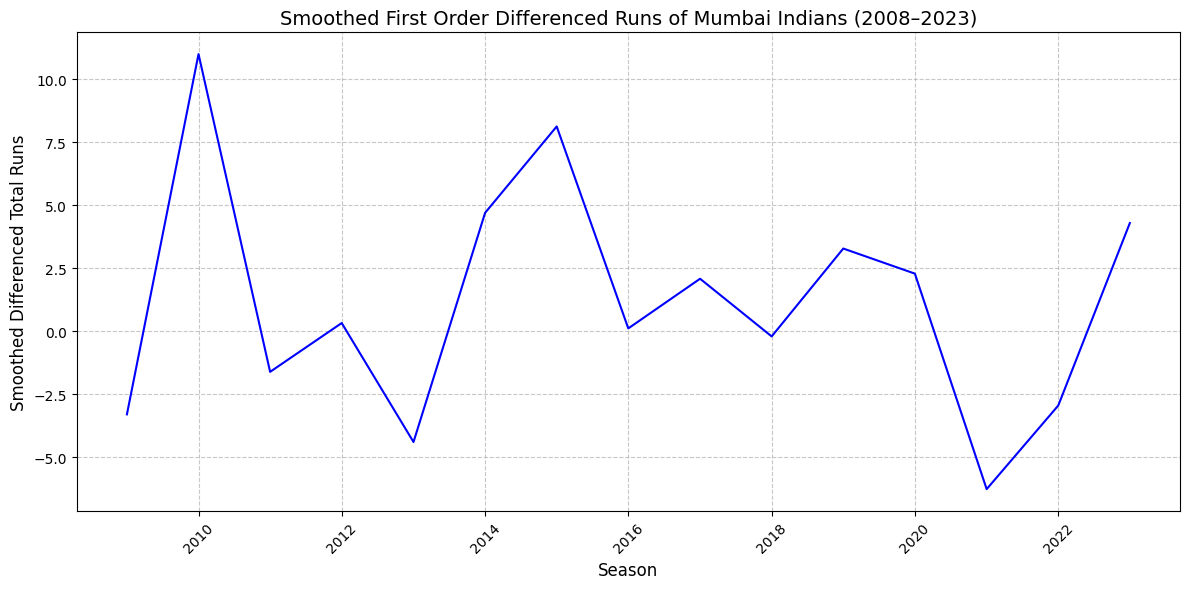

In [343]:

# Ensure 'season' is in datetime format
mumbai_indians_avg_runs['season'] = pd.to_datetime(mumbai_indians_avg_runs['season'], errors='coerce')

# Compute the first order difference (difference between consecutive runs)
mumbai_indians_avg_runs['Diff_1'] = mumbai_indians_avg_runs['average_runs_per_match'] - mumbai_indians_avg_runs['average_runs_per_match'].shift(1)

# Drop NaN values resulting from the differencing
mumbai_indians_avg_runs = mumbai_indians_avg_runs.dropna(subset=['Diff_1'])

# Apply a smoothing technique (rolling mean or Gaussian kernel)
# Using a rolling mean with a window size of 3 for smoothing the differenced series
mumbai_indians_avg_runs['Smoothed_Diff_1'] = mumbai_indians_avg_runs['Diff_1'].rolling(window=3, min_periods=1).mean()

# Plotting the continuous timeline graph
plt.figure(figsize=(12, 6))

# Plot the smoothed first-order differenced data (continuous line)
plt.plot(mumbai_indians_avg_runs['season'], mumbai_indians_avg_runs['Smoothed_Diff_1'], 
         color='blue', linestyle='-', label='Smoothed Differenced Runs')

# Add titles and labels
plt.title('Smoothed First Order Differenced Runs of Mumbai Indians (2008–2023)', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Smoothed Differenced Total Runs', fontsize=12)

# Ensure the x-axis labels (seasons) are readable, and rotate them slightly
plt.xticks(rotation=45, fontsize=10)

# Add gridlines for better visibility
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()


#### ADF Test on Differenced Data

In [256]:
adf_result_diff = adfuller(mumbai_indians_avg_runs['Diff_1'].dropna())
print('ADF Statistic: %f' % adf_result_diff[0])
print('p-value: %f' % adf_result_diff[1])
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.018342
p-value: 0.278589
Critical Values:
	1%: -4.473
	5%: -3.290
	10%: -2.772



### 5.2 Log Transformation

#### Apply Log Transformation

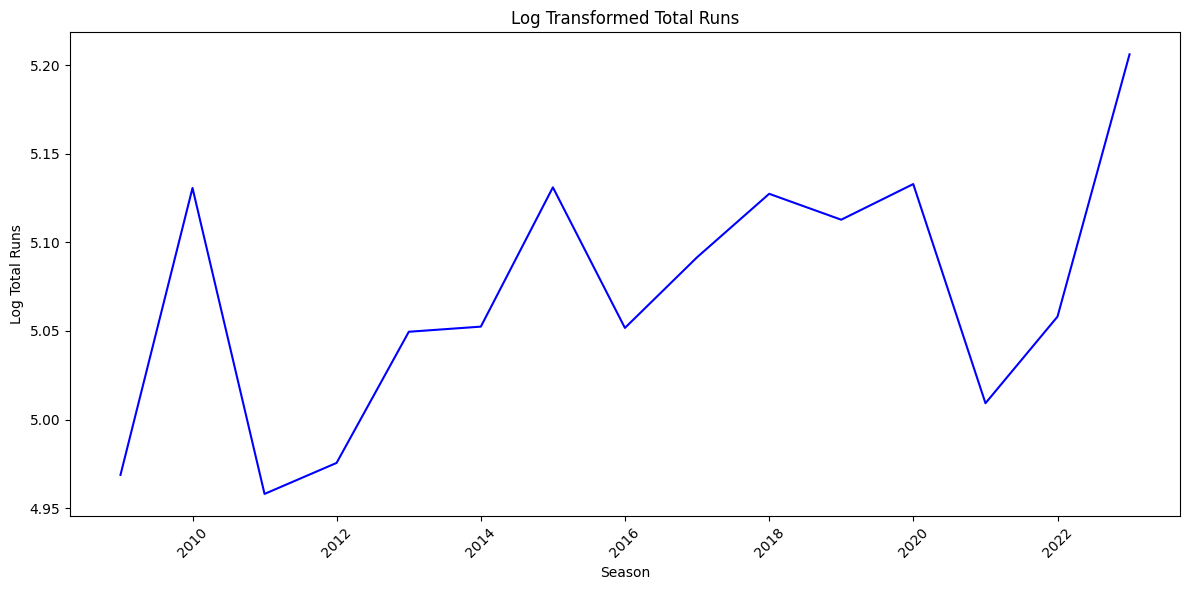

In [259]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'season' column exists in your DataFrame

# Create the log-transformed total runs column
mumbai_indians_avg_runs['Log_Total_Runs'] = np.log(mumbai_indians_avg_runs['average_runs_per_match'])

# Plot the log-transformed total runs with seasons as x-axis
plt.figure(figsize=(12, 6))
plt.plot(mumbai_indians_avg_runs['season'], mumbai_indians_avg_runs['Log_Total_Runs'], color='blue')  # Plot with 'season' on x-axis
plt.title('Log Transformed Total Runs')
plt.xlabel('Season')
plt.ylabel('Log Total Runs')
plt.xticks(rotation=45)  # Rotate season labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


#### Differencing the Log Transformed Data

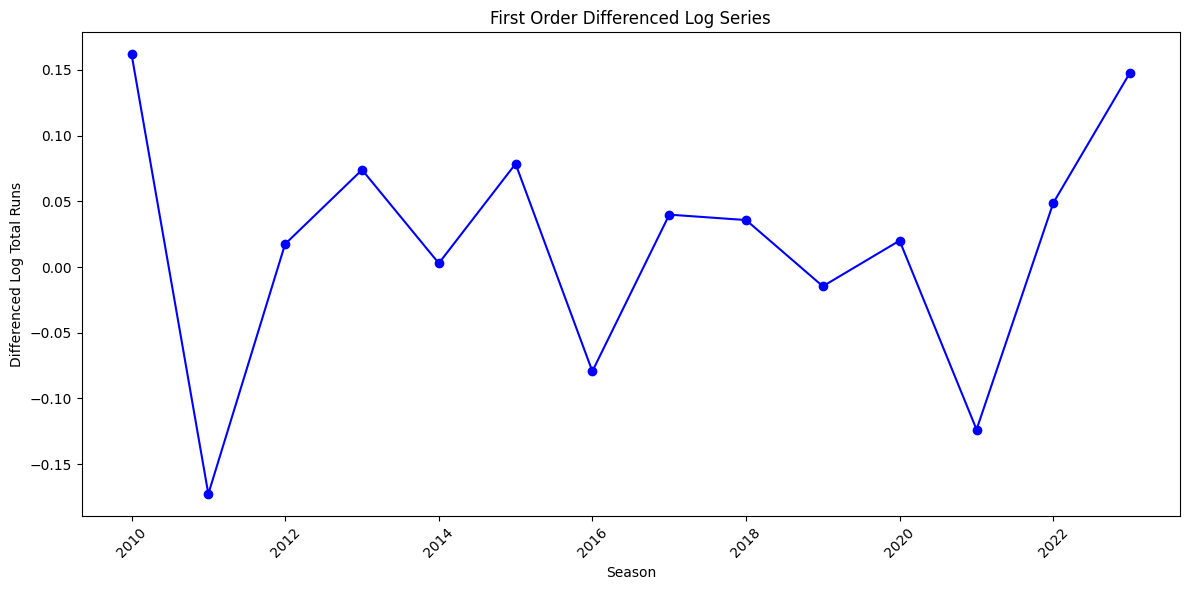

In [262]:
# Assuming the 'season' column exists in your DataFrame

# Calculate the first order differenced log total runs
mumbai_indians_avg_runs['Log_Diff_1'] = mumbai_indians_avg_runs['Log_Total_Runs'] - mumbai_indians_avg_runs['Log_Total_Runs'].shift(1)

# Plot the first order differenced log series with seasons as x-axis
plt.figure(figsize=(12, 6))
plt.plot(mumbai_indians_avg_runs['season'], mumbai_indians_avg_runs['Log_Diff_1'], marker='o', linestyle='-', color='blue')  # Plot with 'season' on x-axis
plt.title('First Order Differenced Log Series')
plt.xlabel('Season')
plt.ylabel('Differenced Log Total Runs')
plt.xticks(rotation=45)  # Rotate season labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


#### ADF Test on Log Differenced Data

In [265]:
# Remove NaN and infinite values
df_cleaned = mumbai_indians_avg_runs['Log_Diff_1'].replace([np.inf, -np.inf], np.nan).dropna()


In [267]:
adf_result_log_diff = adfuller(df_cleaned)
print('ADF Statistic: %f' % adf_result_log_diff[0])
print('p-value: %f' % adf_result_log_diff[1])
print('Critical Values:')
for key, value in adf_result_log_diff[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.326541
p-value: 0.616944
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803


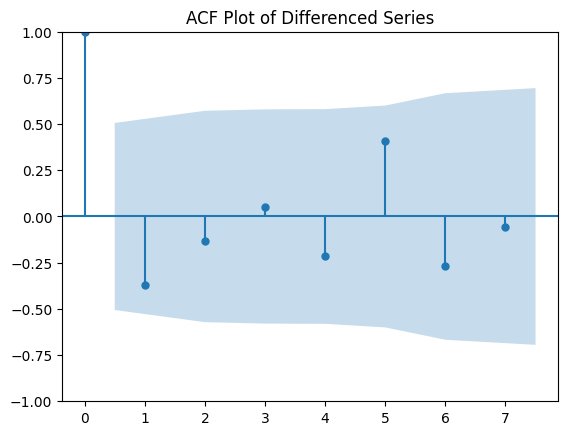

In [269]:
plot_acf(mumbai_indians_avg_runs['Diff_1'].dropna(), lags=7)
plt.title('ACF Plot of Differenced Series')
plt.show()

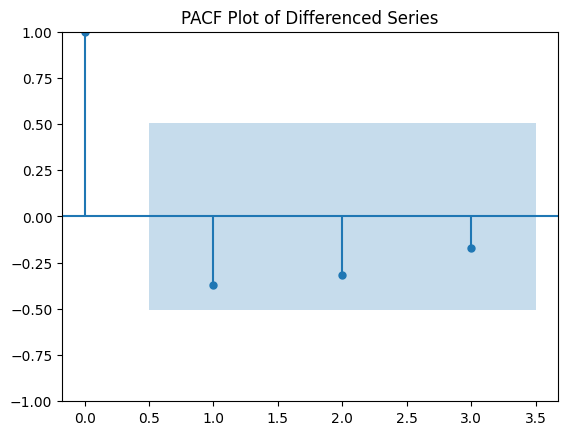

In [271]:
plot_pacf(mumbai_indians_avg_runs['Diff_1'].dropna(), lags=3)
plt.title('PACF Plot of Differenced Series')
plt.show()

In [273]:
mumbai_indians_avg_runs.set_index('season', inplace=True)


In [275]:
num_seasons = len(mumbai_indians_avg_runs)+1
num_seasons

16

# Forecast Using SARIMAX

In [278]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Select the 'average_runs_per_match' column as the dependent variable (endog)
endog = mumbai_indians_avg_runs['average_runs_per_match']

# Fit the SARIMAX model (only pass the univariate series for 'endog')
model = SARIMAX(endog,
                order=(1, 1, 1),  # p, d, q - non-seasonal parameters
                seasonal_order=(1, 1, 1, 4))  # P, D, Q, m - seasonal parameters
result = model.fit()




In [280]:
result

In [282]:
forecast = result.get_forecast(steps=5)  # Forecast for the next season
forecast_runs = forecast.predicted_mean.astype(int)
print(f"Predicted runs for next season: {forecast_runs}")
forecast_runs

Predicted runs for next season: 2024-01-01    170
2025-01-01    156
2026-01-01    170
2027-01-01    176
2028-01-01    175
Freq: YS-JAN, Name: predicted_mean, dtype: int64


2024-01-01    170
2025-01-01    156
2026-01-01    170
2027-01-01    176
2028-01-01    175
Freq: YS-JAN, Name: predicted_mean, dtype: int64

In [284]:
print(mumbai_indians_avg_runs.columns)


Index(['average_runs_per_match', 'Lag_1', 'Lag_2', 'Month', 'Year', 'Diff_1',
       'Smoothed_Diff_1', 'Log_Total_Runs', 'Log_Diff_1'],
      dtype='object')


In [286]:

mumbai_indians_avg_runs.rename(columns={'Year': 'season'}, inplace=True)


In [288]:
mumbai_indians_avg_runs['season'] = pd.to_datetime(mumbai_indians_avg_runs['season']).dt.year


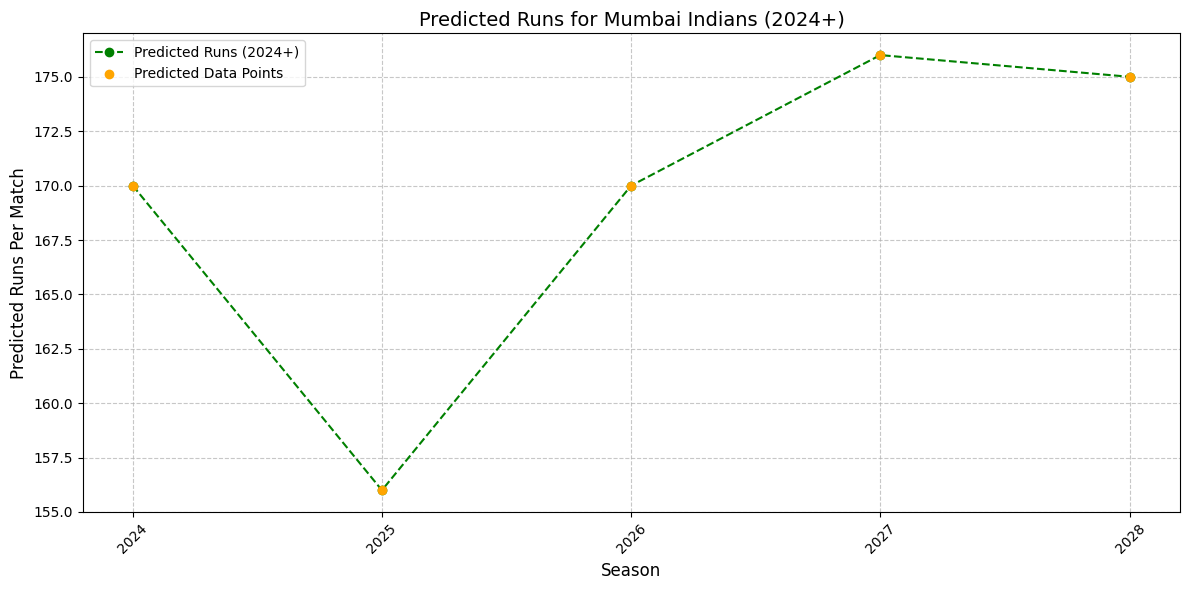

Predicted runs for next season: 2024-01-01    170
2025-01-01    156
2026-01-01    170
2027-01-01    176
2028-01-01    175
Freq: YS-JAN, Name: predicted_mean, dtype: int64


In [318]:

# Create a DataFrame for forecast data for the next 5 seasons (2024 - 2028)
forecast_seasons = pd.date_range(start='2024', periods=5, freq='Y')
forecast_df = pd.DataFrame({'season': forecast_seasons, 'predicted_runs': forecast_runs})

# Plot the predicted data (2024-2028)
plt.figure(figsize=(12, 6))

x_forecast = forecast_df['season']
y_forecast = forecast_df['predicted_runs']
plt.plot(
    x_forecast, 
    y_forecast, 
    color='green', 
    linestyle='--', 
    label='Predicted Runs (2024+)', 
    marker='o'
)

# Add predicted data points as orange scatter plot
plt.scatter(
    x_forecast, 
    y_forecast, 
    color='orange', 
    label='Predicted Data Points', 
    zorder=5
)

# Add titles and labels
plt.title('Predicted Runs for Mumbai Indians (2024+)', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Predicted Runs Per Match', fontsize=12)

# Replace x-ticks with the actual forecasted years
plt.xticks(
    ticks=x_forecast,
    labels=forecast_df['season'].dt.year,
    fontsize=10,
    rotation=45
)

# Add grid and legend
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Output forecasted runs for the next season
print(f"Predicted runs for next season: {forecast_runs}")


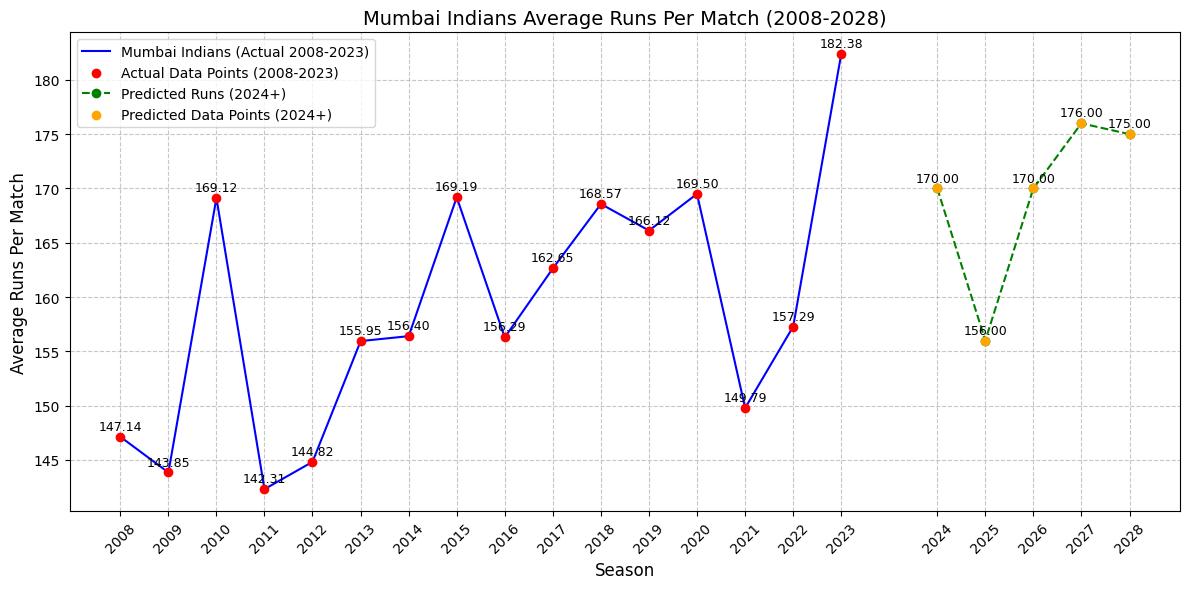

Predicted runs for next season: 


2024-01-01    170
2025-01-01    156
2026-01-01    170
2027-01-01    176
2028-01-01    175
Freq: YS-JAN, Name: predicted_mean, dtype: int64

In [353]:

b 

# Ensure forecast_runs is correctly defined (predicted runs for 2024-2028)
forecast_seasons = pd.date_range(start='2024', periods=5, freq='Y')
forecast_runs = forecast.predicted_mean.astype(int)  # Example predicted data

# Create a DataFrame for forecast data for the next 5 seasons (2024 - 2028)
forecast_df = pd.DataFrame({'season': forecast_seasons, 'predicted_runs': forecast_runs})

# Convert 'a' (actual seasons) to datetime if necessary
a = pd.to_datetime(a)

# Create the combined plot
plt.figure(figsize=(12, 6))

# Plot the smooth line for Mumbai Indians actual average runs per match (2008-2023)
plt.plot(
    a, 
    b, 
    color='blue', 
    linestyle='-', 
    label='Mumbai Indians (Actual 2008-2023)'
)

# Add original data points as red scatter plot for actual data
plt.scatter(
    a, 
    b, 
    color='red', 
    label='Actual Data Points (2008-2023)', 
    zorder=5
)
for i, txt in enumerate(b):
    plt.annotate(
        f"{txt:.2f}",  # Format to two decimals
        (a.iloc[i], b.iloc[i]),  # Positioning the annotation
        textcoords="offset points", 
        xytext=(0, 5),  # Offset the annotation slightly
        ha='center',
        fontsize=9
    )

# Plot the predicted runs (2024-2028)
x_forecast = forecast_df['season']
y_forecast = forecast_df['predicted_runs']
plt.plot(
    x_forecast, 
    y_forecast, 
    color='green', 
    linestyle='--', 
    label='Predicted Runs (2024+)', 
    marker='o'
)

# Add predicted data points as orange scatter plot
plt.scatter(
    x_forecast, 
    y_forecast, 
    color='orange', 
    label='Predicted Data Points (2024+)', 
    zorder=5
)

# Add titles and labels
plt.title('Mumbai Indians Average Runs Per Match (2008-2028)', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Runs Per Match', fontsize=12)

# Combine actual and forecast seasons for x-ticks
combined_seasons = pd.concat([a, x_forecast]).sort_values()

# Set x-ticks to display years from 2008 to 2028
plt.xticks(
    ticks=combined_seasons,  # Combined seasons
    labels=combined_seasons.dt.year,  # Display the years on the x-axis
    fontsize=10,
    rotation=45
)
for i, txt in enumerate(forecast_runs):
    plt.annotate(
        f"{txt:.2f}",  # Format to two decimals
        (x_forecast.iloc[i], y_forecast.iloc[i]),  # Positioning the annotation
        textcoords="offset points", 
        xytext=(0, 5),  # Offset the annotation slightly
        ha='center',
        fontsize=9
    )

# Add grid and legend
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Output forecasted runs for the next season
print(f"Predicted runs for next season: ")
forecast_runs
